In [37]:
import pandas as pd 
import numpy as np
import lazypredict
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
import os
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

In [38]:
df_dataset_origin=pd.read_csv("df_dataset_after_re_processing.csv")

In [39]:
df_dataset_origin.head()

,price,rating,manufacturer,country_of_origin,os,ram,weight,batteries,form_factor,colour,battery_power_rating
0,45900.0,4.2,samsung,India,Android,6.00000,167.0,1 Lithium Polymer,Touchscreen Phone,Midnight Black,6000.0
1,9490.0,4.3,oneplus,India,Android,8.00000,161.0,1 Lithium Polymer,Smartphone,Prism Black,4400.0
2,44000.0,4.2,oppo,India,Android 10,8.00000,196.0,1 Lithium Polymer,Bar,Galactic Blue,4500.0
3,21490.0,4.3,oppo,India,Android,0.03125,175.0,1 Lithium ion,Bar,Aqua Green,4000.0
4,39999.0,4.4,bhagwati products ltd. sp1-1 industrial area k...,India,Android,4.00000,199.0,1 A,Touchscreen Phone,Champagne,6000.0


In [40]:
categorical_cols = [col for col in df_dataset_origin.columns if df_dataset_origin[col].dtype == 'object']
categorical_cols

['manufacturer',
 'country_of_origin',
 'os',
 'batteries',
 'form_factor',
 'colour']

In [41]:

from sklearn.preprocessing import LabelEncoder 
  
# le = LabelEncoder() 
# for col in categorical_cols:
#   df_dataset[col]= le.fit_transform(df_dataset[col]) 

df_dataset=df_dataset_origin
for col in categorical_cols:
  one_hot = pd.get_dummies(df_dataset_origin[col],dtype="int")
  df_dataset = pd.concat([df_dataset, one_hot], axis=1)



In [42]:
df_dataset.columns

Index(['price', 'rating', 'manufacturer', 'country_of_origin', 'os', 'ram',
       'weight', 'batteries', 'form_factor', 'colour',
       ...
       'Sword Black', 'Titanium Sapphire', 'Topaz Blue', 'Tuscany Coral',
       'Ultramarine Blue', 'Vintage Bronze', 'Vinyl Black', 'Violet', 'White',
       'White white'],
      dtype='object', length=215)

In [43]:
y = df_dataset['price']
columns= []
# remove categorcal variable and target
for x in df_dataset.columns:
  if (x not in categorical_cols)  and (x != "price"):
       columns.append(x)

# X = df_dataset[['rating', 'total_reviews', 'manufacturer', 'country_of_origin',
#        'os', 'ram', 'weight', 'batteries', 'form_factor',
#        'colour', 'battery_power_rating']]

X = df_dataset[columns]


In [44]:
X.head()

,rating,ram,weight,battery_power_rating,bhagwati products ltd. sp1-1 industrial area karoli tapukara extn. bhiwadi rajasthan india,g mobile,gionee,google,hmd global,iqoo,...,Sword Black,Titanium Sapphire,Topaz Blue,Tuscany Coral,Ultramarine Blue,Vintage Bronze,Vinyl Black,Violet,White,White white
0,4.2,6.00000,167.0,6000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.3,8.00000,161.0,4400.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.2,8.00000,196.0,4500.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.3,0.03125,175.0,4000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.4,4.00000,199.0,6000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,random_state=42)

scaler = StandardScaler()
X_train_std_scaler=scaler.fit_transform(X_train)
X_test_std_scaler=scaler.transform(X_test)
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train_std_scaler, y_train)
score_train = model.score(X_train_std_scaler, y_train)
score_test = model.score(X_test_std_scaler, y_test)
print("The score train of first model:",score_train)
print("The score test of first model:",score_test)


The score train of first model: 0.835499458348812
The score test of first model: -0.24089235664542685


In [46]:
best_score = float('-inf')
best_features = []
current_features = []
independent_vars=df_dataset_origin.columns
independent_vars=independent_vars[1:-1]

In [47]:

filename_model = 'random_forest_regressor.sav'
dir_current=os.getcwd()
dir_store_model=os.path.join(dir_current,"models",filename_model)
while True:
    best_feature = None
    for feature in independent_vars:
        # print(feature)
        selected_features = current_features + [feature]
        X = df_dataset_origin[selected_features]
        for col in X.columns:
            if col in categorical_cols:
                one_hot = pd.get_dummies(df_dataset_origin[col],dtype="int")
                X = pd.concat([X, one_hot], axis=1)
                X.drop(columns=[col],inplace=True)
        y = df_dataset_origin["price"]
        
        X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,random_state=42)

        scaler = StandardScaler()
        X_train_std_scaler=scaler.fit_transform(X_train)
        X_test_std_scaler=scaler.transform(X_test)

        model = RandomForestRegressor(n_estimators=100, random_state=10)
        # model.fit(X, y)
        model.fit(X_train_std_scaler, y_train)
        # score = model.score(X, y)
        score = model.score(X_test_std_scaler, y_test)
        if score > best_score:
            best_score = score
            best_feature = feature
            pickle.dump(model, open(dir_store_model, 'wb')) #store model
    if best_feature is None:
        break
    current_features.append(best_feature)
    independent_vars = independent_vars.drop(best_feature)

print("The number of features orgin:", len(df_dataset_origin.columns)-1)
print("The number of features:", len(current_features))
print("Best features:", current_features)
print("Best score:", best_score)


The number of features orgin: 10
The number of features: 1
Best features: ['batteries']
Best score: 0.01330481094743785


In [67]:
loaded_model = pickle.load(open(dir_store_model, 'rb'))
X = df_dataset_origin[current_features]
for col in X.columns:
            if col in categorical_cols:
                one_hot = pd.get_dummies(df_dataset_origin[col],dtype="int")
                X = pd.concat([X, one_hot], axis=1)
                X.drop(columns=[col],inplace=True)
y = df_dataset_origin["price"]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,random_state=42)

scaler = StandardScaler()
X_train_std_scaler=scaler.fit_transform(X_train)
X_test_std_scaler=scaler.transform(X_test)


result_test = loaded_model.score(X_test_std_scaler, y_test)
result_train = loaded_model.score(X_train_std_scaler, y_train)
print("The score of last model test:",result_test)
print("The score of last model train:",result_train)

The score of last model test: 0.01330481094743785
The score of last model train: 0.006000670787349338


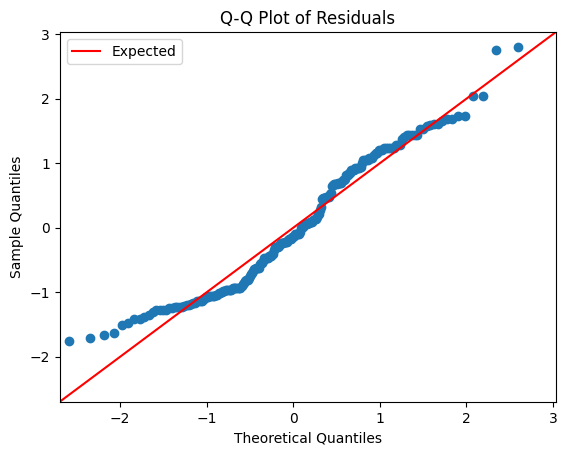

In [52]:
residuals = y_train - loaded_model.predict(X_train_std_scaler)

import statsmodels.api as sm

# sm.qqplot(residuals, line='s')
sm.qqplot(residuals,fit=True,line="45")
plt.title('Q-Q Plot of Residuals')
plt.plot([], [], color='red', label='Expected')
plt.legend()
plt.show()

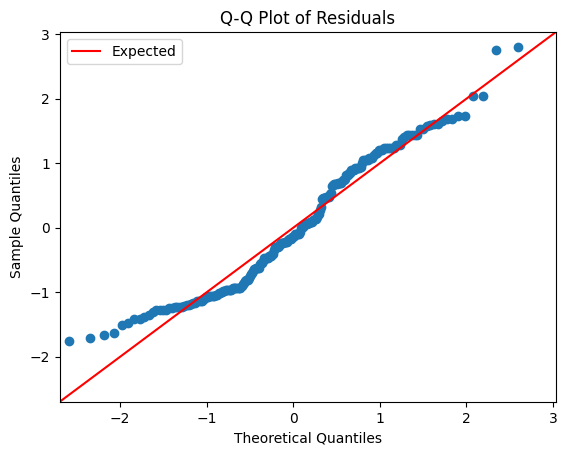

In [51]:
residuals = y_train - loaded_model.predict(X_train_std_scaler)

import statsmodels.api as sm

# sm.qqplot(residuals, line='s')
sm.qqplot(residuals,fit=True,line="45")
plt.title('Q-Q Plot of Residuals')
plt.plot([], [], color='red', label='Expected')
plt.legend()
plt.show()

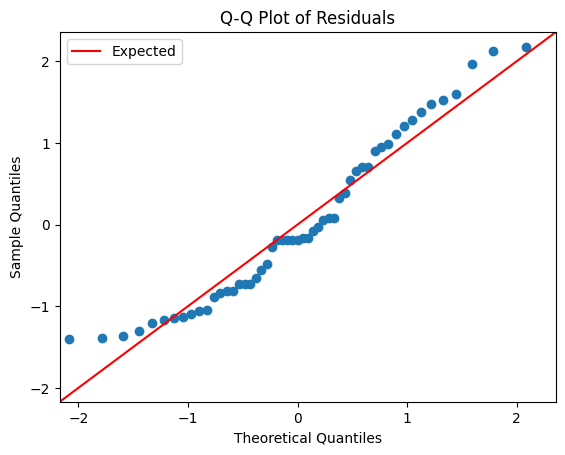

In [49]:
residuals = y_test - loaded_model.predict(X_test_std_scaler)

import statsmodels.api as sm

sm.qqplot(residuals,fit=True,line="45")
plt.title('Q-Q Plot of Residuals')
plt.plot([], [], color='red', label='Expected')
plt.legend()
plt.show()